<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FIP_Libra_DeepLearning_GraphSAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl

In [ ]:
!pip install node2vec

In [ ]:
from node2vec.edges import HadamardEmbedder
from gensim.models import Word2Vec
import random
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import torch.optim as optim
import dgl.function as fn
from dgl.nn import SAGEConv

In [ ]:
!pip install -q torch-geometric

In [ ]:
from google.colab import drive
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
#from dgl.nn import GraphConv
#from dgl.nn import SAGEConv
import dgl.nn as dglnn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.nn import GATConv

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
path='drive/MyDrive/Term_05/FinalProposal/Data/'
pathBasePaper='drive/MyDrive/Term_06/BasePaper/Data/'

In [ ]:
train_edgelist=np.load(path+'train_edgelist.npy')
test_edgelist=np.load(path+'test_edgelist.npy')
train_edge_weight=np.load(path+'train_edge_weight.npy')
test_edge_weight=np.load(path+'test_edge_weight.npy')
train_elabel=np.load(path+'edge_y_train.npy')
test_elabel=np.load(path+'edge_y_test.npy')

In [ ]:
test_edge_index=np.load(path+'test_edge_index.npy')
train_edge_index=np.load(path+'train_edge_index.npy')

In [ ]:
train_x=np.load(path+'train_x.npy')
train_y=np.load(path+'train_y.npy')
test_x=np.load(path+'test_x.npy')
test_y=np.load(path+'test_y.npy')

In [ ]:
nodedf=pd.read_csv(path + 'LibraReduceNodeInfo.csv')
edgedf=pd.read_csv(path + 'LibraReduceEdgeInfo.csv')

In [ ]:
print('number of edge:', edgedf.shape)
print('number of node:',nodedf.shape)

number of edge: (370918, 6)
number of node: (202426, 22)


In [ ]:
loaded_trainData=np.load(path+'train_node.npy')
loaded_testData=np.load(path+'test_node.npy')
traindf= pd.DataFrame(loaded_trainData, columns=['NewNodeId'])
testdf= pd.DataFrame(loaded_testData, columns=['NewNodeId'])

traindf['NewNodeId'] = traindf['NewNodeId'].astype(int)
traindata_df = pd.merge(traindf,nodedf, on='NewNodeId', how='inner')
testdata_df = pd.merge(testdf,nodedf, on='NewNodeId', how='inner')

In [ ]:
print(len(traindata_df))
print(len(testdata_df))
print(len(train_edgelist))
print(len(test_edgelist))

161940
40486
230907
16222


In [ ]:
# train_idx=torch.tensor(traindata_df.index, dtype = torch.long)
# test_idx=torch.tensor(testdata_df.index, dtype = torch.long)
# #valid_idx=torch.tensor(validate.index, dtype = torch.long)

In [ ]:
edgedf.insert(1, "elabel", 0)
edgedf["elabel"] = np.where(edgedf["nr_alerts"] > 0, 1, 0)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ,'elabel' ]
G=nx.from_pandas_edgelist(
            df=edgedf,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())

number_of_edges:  370918
number_of_nodes:  202426


# Create Train and Test Graph for edge Classification

In [ ]:
df1=pd.DataFrame(train_edgelist)
df2=pd.DataFrame(train_edge_weight)
train_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#--------------------------------------------------------------------------------
train_edgelist_G = train_edgelist_G.rename(columns={'0_x': 'id_source'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_x': 'id_destination'})
train_edgelist_G = train_edgelist_G.rename(columns={'0_y': 'cum_amount'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
train_edgelist_G['eLabel']=pd.DataFrame(train_elabel)

In [ ]:
len(train_edgelist_G)

230907

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
train_G=nx.from_pandas_edgelist(
            df=train_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',train_G.number_of_edges())
print('number_of_nodes: ',train_G.number_of_nodes())

number_of_edges:  230907
number_of_nodes:  135447


In [ ]:
df1=pd.DataFrame(test_edgelist)
df2=pd.DataFrame(test_edge_weight)
test_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#--------------------------------------------------------------------------------
test_edgelist_G = test_edgelist_G.rename(columns={'0_x': 'id_source'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_x': 'id_destination'})
test_edgelist_G = test_edgelist_G.rename(columns={'0_y': 'cum_amount'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
test_edgelist_G['eLabel']=pd.DataFrame(test_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
test_G=nx.from_pandas_edgelist(
            df=test_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',test_G.number_of_edges())
print('number_of_nodes: ',test_G.number_of_nodes())

number_of_edges:  16222
number_of_nodes:  12963


In [ ]:
#train_G = G.subgraph(loaded_trainData)
#test_G = G.subgraph(loaded_testData)
print('number_of_edges train_graph: ',train_G.number_of_edges())
print('number_of_nodes train_graph: ',train_G.number_of_nodes())
print('number_of_edges test_graph: ',test_G.number_of_edges())
print('number_of_nodes test_graph: ',test_G.number_of_nodes())


number_of_edges train_graph:  230907
number_of_nodes train_graph:  135447
number_of_edges test_graph:  16222
number_of_nodes test_graph:  12963


# Set Attribute  to Train and Test Graph and Get Edge Anomaluse

In [ ]:
trainNode_G=list(train_G.nodes())
trainNode=pd.DataFrame(trainNode_G, columns=['NewNodeId'])
traindata_df = pd.merge(trainNode,nodedf, on='NewNodeId', how='inner')

testNode_G=list(test_G.nodes())
testNode=pd.DataFrame(testNode_G, columns=['NewNodeId'])
testdata_df = pd.merge(testNode,nodedf, on='NewNodeId', how='inner')

In [ ]:
# traindata_df.set_index('NewNodeId', inplace=True)
# testdata_df.set_index('NewNodeId', inplace=True)

In [ ]:
#featurName=['f_amount_in','f_amount_out','f_egored_amount_in','f_egored_amount_out','Label']
featurName=['f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']

trainNode_x=traindata_df[featurName].values
trainNode_y=traindata_df['L_alert'].values

testNode_x=testdata_df[featurName].values
testNode_y=testdata_df['L_alert'].values

In [ ]:
result = testdata_df[testdata_df['L_alert']==1]

# Node embedding and edge embedding

In [ ]:
node2vec = Node2Vec(train_G, dimensions=3)
# Embed nodes
modelTG = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = modelTG.wv

modelTG.wv.save_word2vec_format(pathBasePaper +  'EMBEDDING_Train.emb')

Computing transition probabilities:   0%|          | 0/135447 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [04:01<00:00, 24.15s/it]


In [ ]:
modelTG.save(pathBasePaper +'modelTsTG_Train.wv')

In [ ]:
node2vec = Node2Vec(test_G, dimensions=3)
# Embed nodes
modelTstG = node2vec.fit(window=10, min_count=1, batch_words=4)
embeddings = modelTstG.wv

modelTstG.wv.save_word2vec_format(pathBasePaper +  'EMBEDDING_Test.emb')

Computing transition probabilities:   0%|          | 0/12963 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


In [ ]:
modelTstG.save(pathBasePaper +'modelTstG_test.wv')

In [ ]:
#---------------------Load Data Model -------------------------------------------------
train_node_embeddings =KeyedVectors.load_word2vec_format(pathBasePaper +  'EMBEDDING_Train.emb')
Train_model = Word2Vec.load(pathBasePaper + 'modelTsTG_Train.wv')
test_node_embeddings =KeyedVectors.load_word2vec_format(pathBasePaper +  'EMBEDDING_Test.emb')
Test_model = Word2Vec.load(pathBasePaper + 'modelTstG_test.wv')

In [ ]:
train_graph=dgl.DGLGraph(train_G)
test_graph=dgl.DGLGraph(test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=Train_model.wv)

In [ ]:
node_features.shape

In [ ]:
train_embeddings=Train_model.wv
node_embeddingslist = train_embeddings.vectors.tolist()

node_features=torch.tensor(node_embeddingslist , dtype = torch.float)
train_graph.ndata['feat'] = node_features
#---------------------- Train Node Label ---------------------------------------------
train_graph.ndata['label'] = torch.tensor(traindata_df['L_alert'].values)


edges_embslist=[]
for edge in train_G.edges:
     node1, node2 = edge
     edge_embeddingitem = edges_embs[(str(node1),str(node2))]
     edges_embslist.append(edge_embeddingitem)

train_graph.edata['AttrEge'] =torch.tensor(edges_embslist)
train_graph.edata['eLabel']=torch.tensor(train_edgelist_G['eLabel'].values, dtype=torch.float32)


<ipython-input-72-e87069f3734c>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_graph.edata['AttrEge'] =torch.tensor(edges_embslist)


In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=Test_model.wv)
test_embeddings=Test_model.wv
node_embeddingslist = test_embeddings.vectors.tolist()

node_features=torch.tensor(node_embeddingslist , dtype = torch.float)
test_graph.ndata['feat'] = node_features
#---------------------- Train Node Label ---------------------------------------------
test_graph.ndata['label'] = torch.tensor(testdata_df['L_alert'].values)


edges_embslist=[]
for edge in test_G.edges:
     node1, node2 = edge
     edge_embeddingitem = edges_embs[(str(node1),str(node2))]
     edges_embslist.append(edge_embeddingitem)

test_graph.edata['AttrEge'] =torch.tensor(edges_embslist)
test_graph.edata['eLabel']=torch.tensor(test_edgelist_G['eLabel'].values, dtype=torch.float32)


In [ ]:
edge_list_src, edge_list_dst = train_graph.edges()
edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
train_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)
train_edge_index=torch.tensor(train_edge_index ,dtype=torch.long)

<ipython-input-26-23476a1285d8>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
<ipython-input-26-23476a1285d8>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
<ipython-input-26-23476a1285d8>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_edge_index=torch.tensor(train_edge_index ,dtype=torch.long)


In [ ]:
edge_list_src, edge_list_dst = test_graph.edges()
edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
test_edge_index = torch.cat((edge_list_src.unsqueeze(0), edge_list_dst.unsqueeze(0)), dim=0)
test_edge_index=torch.tensor(test_edge_index ,dtype=torch.long)

<ipython-input-27-c210dc5d2f2c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_src_tensor = torch.tensor(edge_list_src, dtype=torch.long)
<ipython-input-27-c210dc5d2f2c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_list_dst_tensor = torch.tensor(edge_list_dst, dtype=torch.long)
<ipython-input-27-c210dc5d2f2c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_edge_index=torch.tensor(test_edge_index ,dtype=torch.long)


# Create Model GAT Model

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super(SAGE, self).__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [ ]:
def evaluate(model,test_loader , graph):
    torch.backends.cudnn.deterministic = True
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            logits = model(graph,inputs)
            _, predicted = torch.max(logits, 1)

            accuracy = (predicted == labels).float().mean().item()


        print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
        fpr, tpr, thresholds = roc_curve(labels, predicted)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Classification')
        plt.legend(loc='lower right')
        plt.show()

    return accuracy

In [ ]:
def train (model,train_loader , epochs , class_weights , learning_rate , graph):
    torch.backends.cudnn.deterministic = True
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list: list = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(graph, inputs)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        if epoch % 5 == 0:
            print(f"In epoch {epoch}, loss: {loss:.3f})"
                )
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Chart')
    plt.show()
    return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def Get_class_weights(data):
    class_labels=torch.unique(data)
    class_labels=np.array(class_labels)
    y=np.array(data)
    class_weight =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
    class_weights=torch.tensor(class_weight ,  dtype = torch.float)
    return class_weights

# Node Classification

In [ ]:
train_edge_index.shape

(2, 230907)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
traindata_df['f_amount_in_scaled'] = scaler.fit_transform(traindata_df[['f_amount_in']])
traindata_df['f_amount_out_scaled'] = scaler.fit_transform(traindata_df[['f_amount_out']])
testdata_df['f_amount_in_scaled'] = scaler.fit_transform(testdata_df[['f_amount_in']])
testdata_df['f_amount_out_scaled'] = scaler.fit_transform(testdata_df[['f_amount_out']])



traindata_df['f_nr_trans_in_scaled'] = scaler.fit_transform(traindata_df[['f_nr_trans_in']])
traindata_df['f_nr_trans_out_scaled'] = scaler.fit_transform(traindata_df[['f_nr_trans_out']])
testdata_df['f_nr_trans_in_scaled'] = scaler.fit_transform(testdata_df[['f_nr_trans_in']])
testdata_df['f_nr_trans_out_scaled'] = scaler.fit_transform(testdata_df[['f_nr_trans_out']])



featurName=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in_scaled','f_nr_trans_out_scaled']
X_train_Node=traindata_df[featurName].values.tolist()
y_train_Node=traindata_df['L_alert'].values
X_train_Node = torch.tensor(X_train_Node ,dtype=torch.float)
y_train_Node = torch.tensor(y_train_Node ,dtype=torch.long)

X_test_Node=testdata_df[featurName].values.tolist()
y_test_Node=testdata_df['L_alert'].values
X_test_Node = torch.tensor(X_test_Node ,dtype=torch.float)
y_test_Node = torch.tensor(y_test_Node ,dtype=torch.long)

In [ ]:
Node_class_weights=Get_class_weights(y_train_Node)

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.1
num_classes=2
in_feats = X_train_Node.shape[1]
hid_feats = 64 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1
SAGENModel = SAGE(in_feats=in_feats, hid_feats=hid_feats, out_feats=num_classes)
optimizer =torch.optim.Adam(SAGENModel.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=Node_class_weights)


batch_size_node =len(X_train_Node)
batch_size_node_tst =len(X_test_Node)
epochs=80
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_dateset=torch.utils.data.TensorDataset(X_train_Node,y_train_Node)
train_loader_node=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_node, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(X_test_Node,y_test_Node)
test_loader_node=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_node_tst, shuffle=False )

In epoch 0, loss: 1.341)
In epoch 5, loss: 0.429)
In epoch 10, loss: 0.211)
In epoch 15, loss: 0.208)
In epoch 20, loss: 0.199)
In epoch 25, loss: 0.146)
In epoch 30, loss: 0.114)
In epoch 35, loss: 0.084)
In epoch 40, loss: 0.113)
In epoch 45, loss: 0.102)
In epoch 50, loss: 0.098)
In epoch 55, loss: 0.075)
In epoch 60, loss: 0.082)
In epoch 65, loss: 0.159)
In epoch 70, loss: 0.080)
In epoch 75, loss: 0.068)


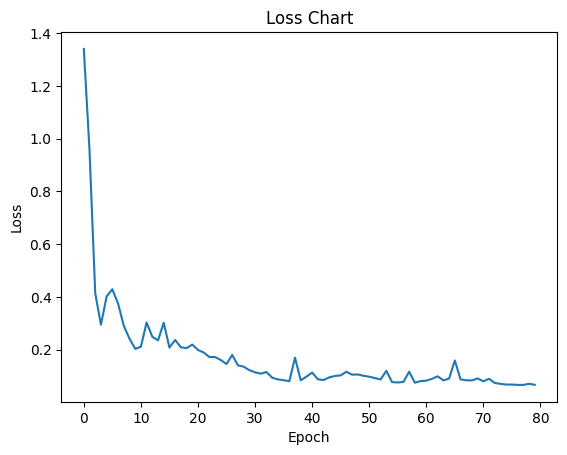

In [ ]:
torch.backends.cudnn.deterministic = True
Node_model=train(model=SAGENModel, train_loader=train_loader_node, epochs=epochs , class_weights=Node_class_weights , learning_rate=learning_rate , graph=train_graph )

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     12889
           1       0.08      1.00      0.15        74

    accuracy                           0.94     12963
   macro avg       0.54      0.97      0.56     12963
weighted avg       0.99      0.94      0.96     12963



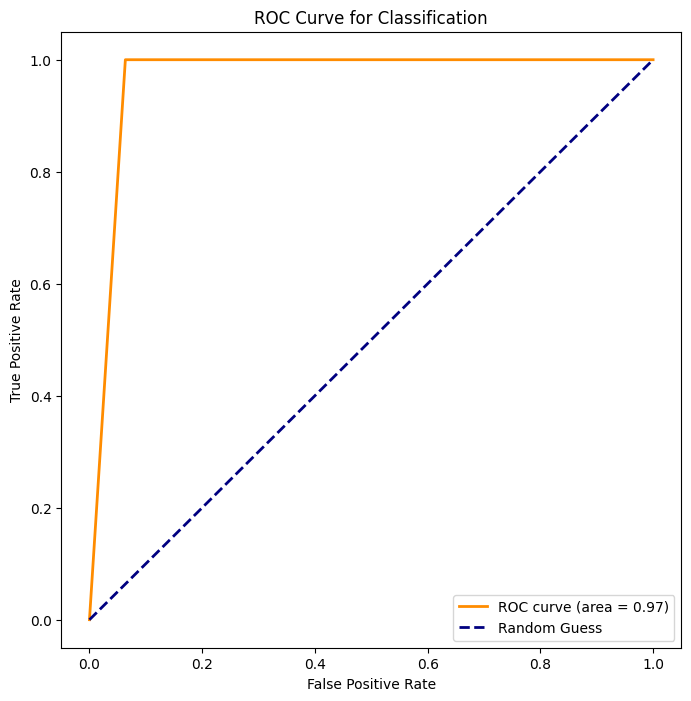

0.9366658926010132

In [ ]:
evaluate(model=Node_model, test_loader=test_loader_node, graph=test_graph)